In [60]:
import pandas as pd
pd.set_option('display.max_columns', None)  # Mostra todas as colunas
import numpy as np
from scipy.stats import chi2_contingency
import scipy.stats as stats


# Pipelines para tratar dados futuros
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

#seleção e validação de modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Pré-processamento para incluir no pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

# Modelos
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


from sklearn import set_config
set_config(transform_output="pandas")


import folium # mapa


import matplotlib.pyplot as plt
import seaborn as sns


import joblib

from sklearn.base import BaseEstimator, TransformerMixin


1) Entendimento do Negócio (Business Understanding)

Definir os objetivos do projeto e os requisitos do negócio.
Formular perguntas de negócio que o projeto deve responder.
Planejar a estratégia e os objetivos do projeto.


------------------
Será feito um trabalho de classificação para tentar prever a possibilidade de churn dos clientes de uma companhia fictícia de telecomunicações.
Com base nos dados fornecidos, o modelo deve prever quais dos novos clientes tem a possibilidade de churn. Tal previsão permite adotar uma estratégia para diminuir a evasão de clientes de sua base.

2) Entendimento dos Dados (Data Understanding)

Coletar dados iniciais.
Descrever os dados e verificar sua qualidade.
Explorar os dados para identificar padrões e outliers.


In [3]:
df = pd.read_csv('..\data\customer_churn.csv')
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Danbr\AppData\Local\Temp\ipykernel_12476\2771488798.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('..\data\customer_churn.csv')


,CustomerID,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,CLTV,Churn Value
0,3668-QPYBK,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,3239,1
1,9237-HQITU,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,2701,1
2,9305-CDSKC,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,5372,1
3,7892-POOKP,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,5003,1
4,0280-XJGEX,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,5340,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7032 non-null   object 
 1   Latitude           7032 non-null   float64
 2   Longitude          7032 non-null   float64
 3   Gender             7032 non-null   object 
 4   Senior Citizen     7032 non-null   object 
 5   Partner            7032 non-null   object 
 6   Dependents         7032 non-null   object 
 7   Tenure Months      7032 non-null   int64  
 8   Phone Service      7032 non-null   object 
 9   Multiple Lines     7032 non-null   object 
 10  Internet Service   7032 non-null   object 
 11  Online Security    7032 non-null   object 
 12  Online Backup      7032 non-null   object 
 13  Device Protection  7032 non-null   object 
 14  Tech Support       7032 non-null   object 
 15  Streaming TV       7032 non-null   object 
 16  Streaming Movies   7032 

In [4]:
# Separando as colunas categóricas
cat_col = df.select_dtypes(include=['object']).columns.tolist()

# Separando as colunas numéricas
num_col = df.select_dtypes(include=['number']).columns.tolist()

# Removendo 'Churn Value' da lista de colunas numéricas, se presente
if 'Churn Value' in num_col:
    num_col.remove('Churn Value')


print("Colunas categóricas:")
print(cat_col)
print("\nColunas numéricas:")
print(num_col)


Colunas categóricas:
['CustomerID', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']

Colunas numéricas:
['Latitude', 'Longitude', 'Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']


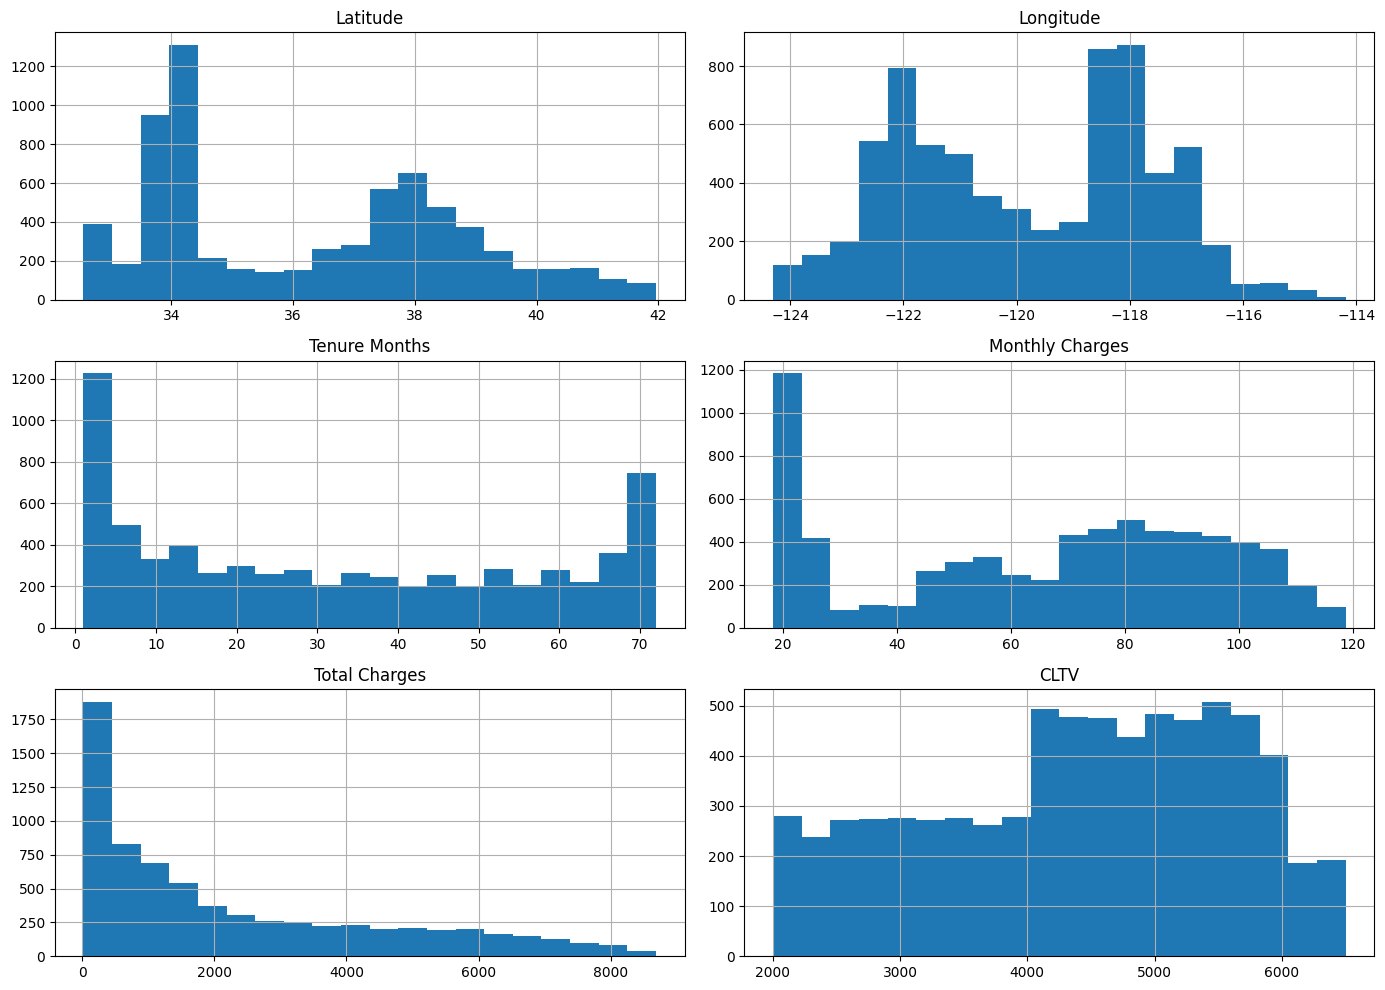

In [5]:
# Plotando histogramas para colunas numéricas
df[num_col].hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()


Em latitude e longitude vamos avaliar usando um mapa, a distribuição mostra que são clientes de alguma área específica.
Em tenure months temos uma boa concentração de novos clientes, assim como clientes muito antigos. Isso mostra como a empresa lidou muito bem com seus primeiros clientes, porém não pode manter alto nível de rentenção entre clientes de 20 e 60 meses.
Em monthly charges e total charges, indica que a maioria dos clientes optou por serviços mais baratos.
CLTV, mostra o valor vitalício do cliente, que é uma previsão de quanta receita aquele cliente irá retornar para a companhia, o gráfico mostra concentração em clientes entre 4000 a 6000. Os dados mostram que a companhia pode investir mais em clientes acima de 6000, para que aumente esta parcela, sendo clientes muito interessantes, aqueles com o maior CLTV.

In [6]:
# Criando um mapa centrado nas coordenadas médias
mapa = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=6)

# Adicionando marcadores para cada cliente
for index, row in df.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['CustomerID']).add_to(mapa)

# Exibindo o mapa
mapa.save('customer_map.html')


É possível olhar que no mapa, mostra a distribuição dos clientes no estado da calinfornia. A informação de que os clientes eram deste estado já estava presente na documentação da base de dados.

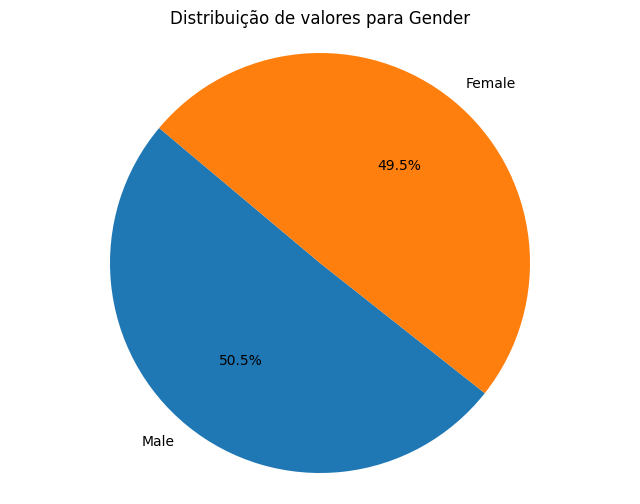

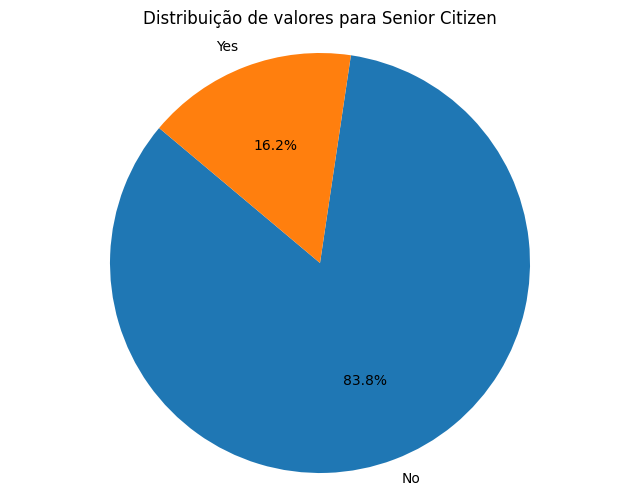

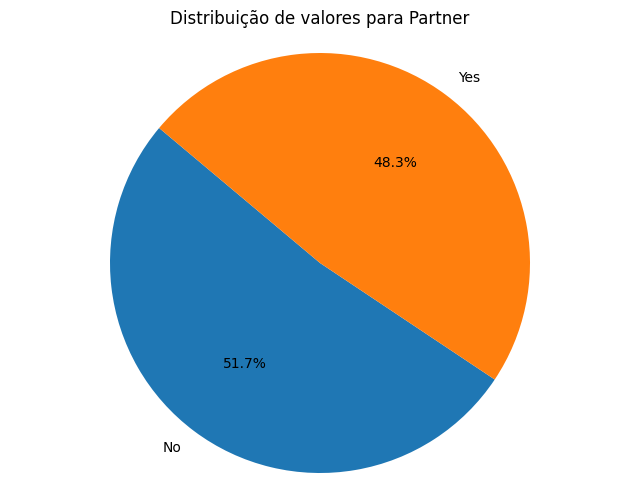

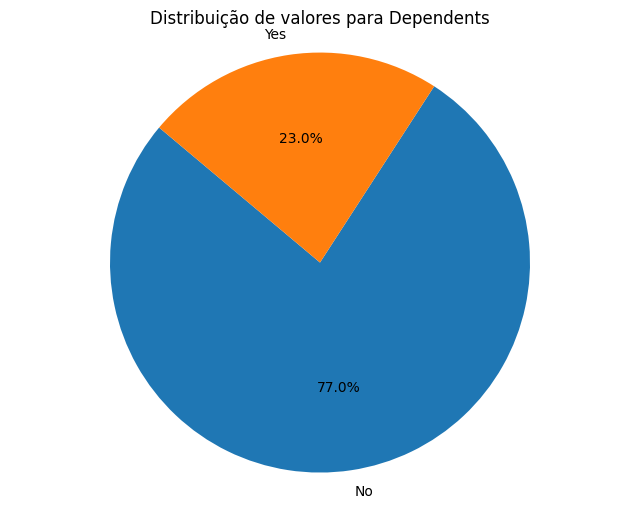

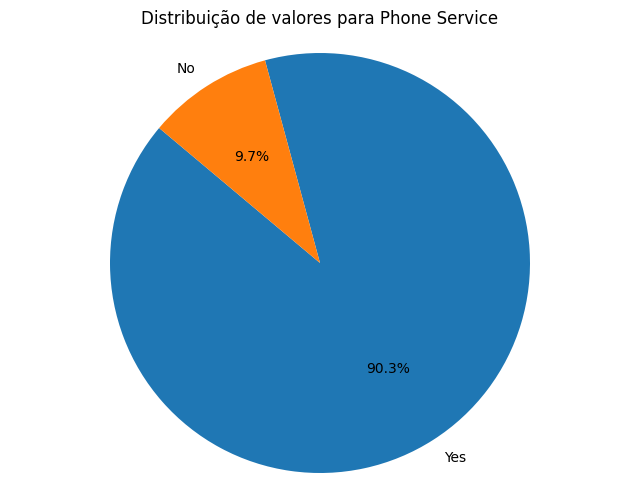

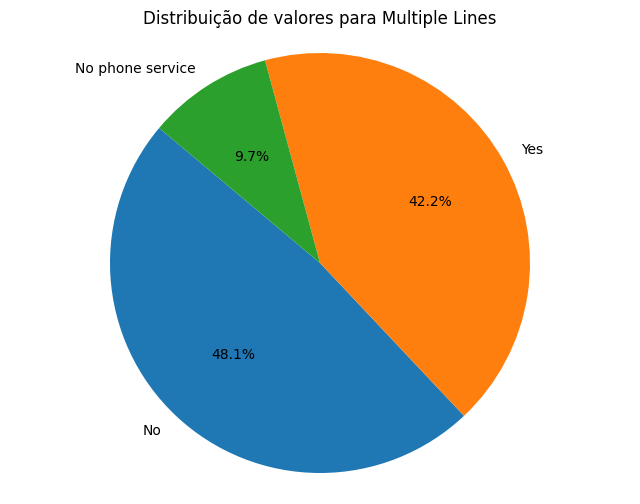

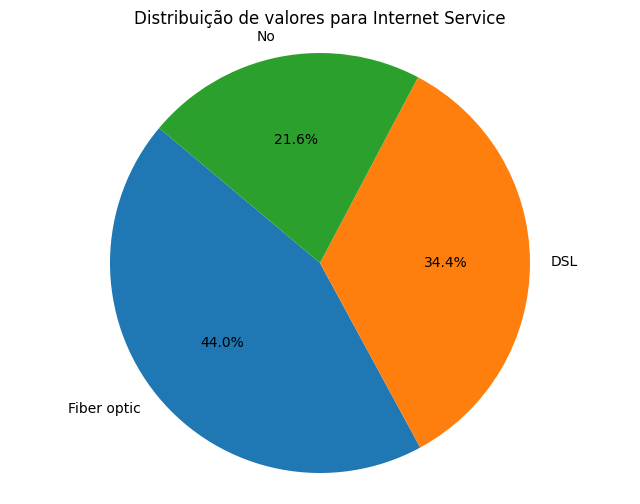

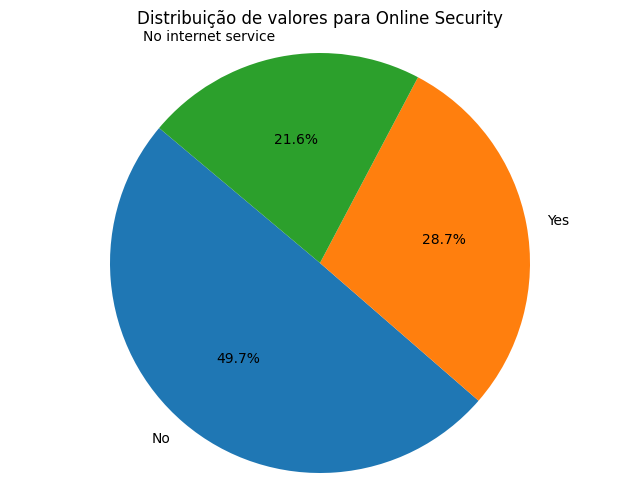

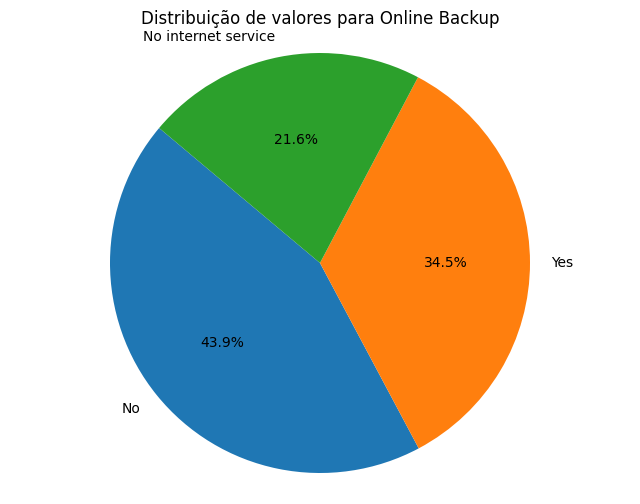

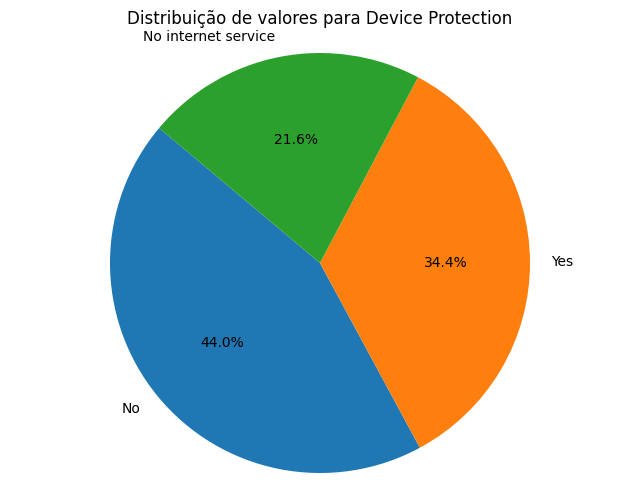

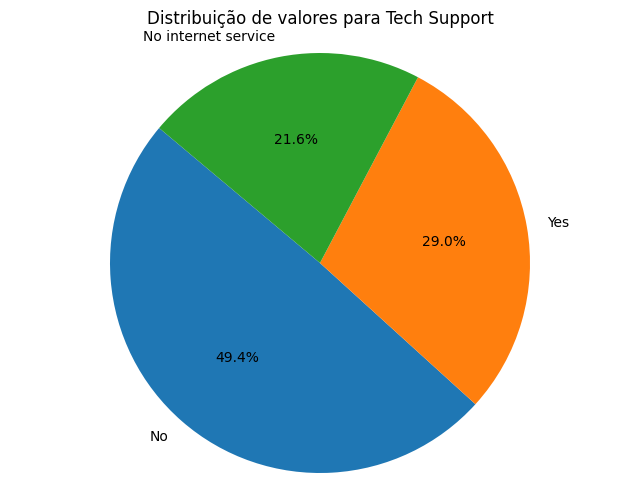

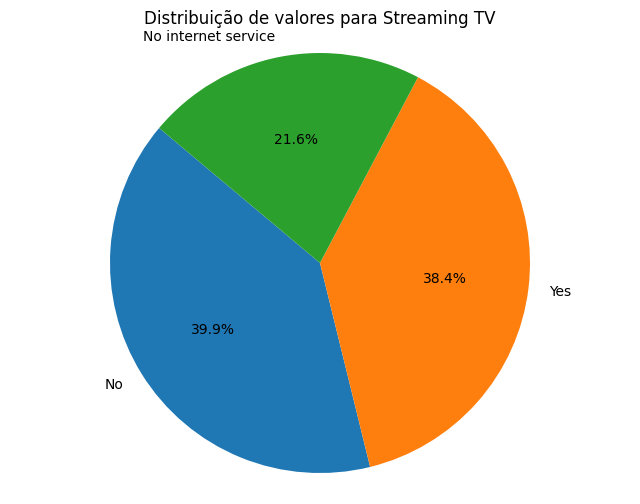

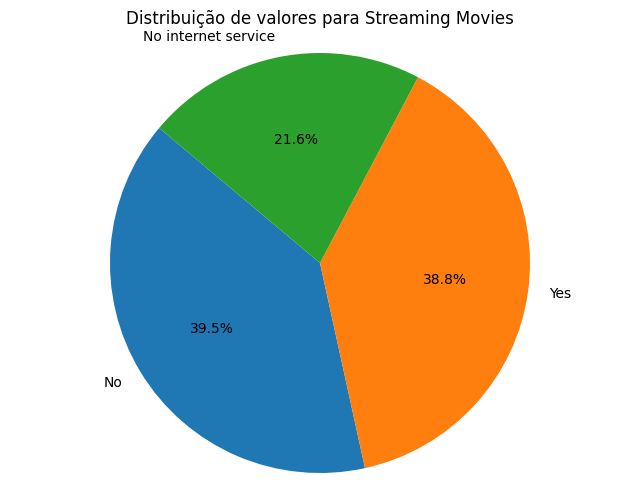

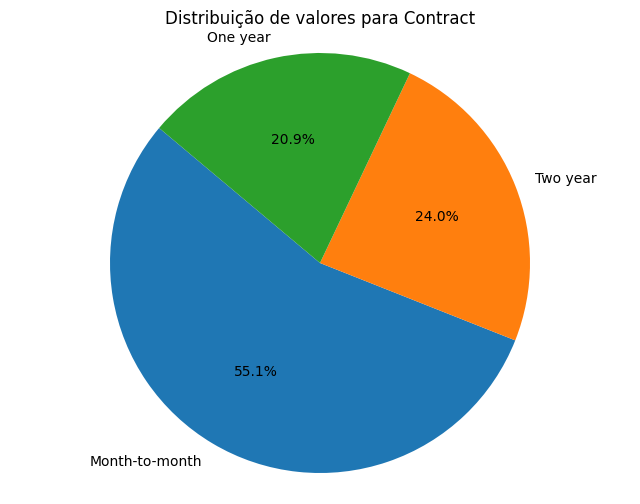

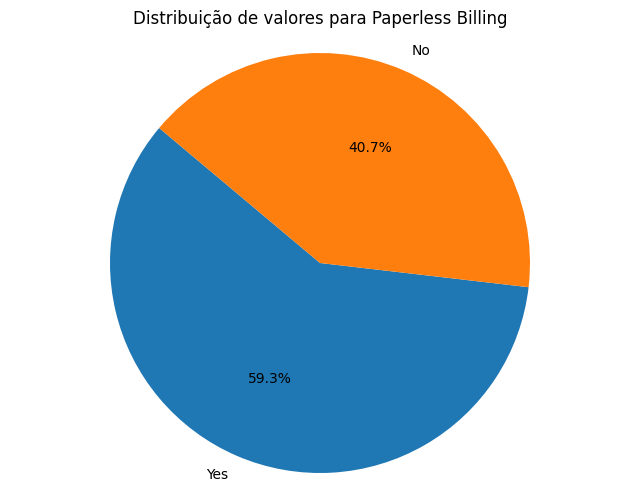

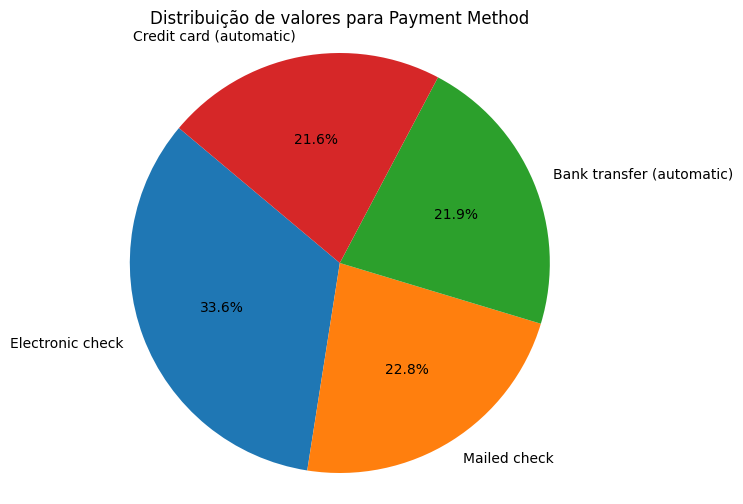

In [17]:
# Iterar sobre as colunas categóricas
for cat in cat_col:
    if cat != 'CustomerID':  # Ignorar a coluna 'CustomerID'
        # Calcular contagem de valores
        counts = df[cat].value_counts()
        
        # Plotar gráfico de pizza
        plt.figure(figsize=(8, 6))
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
        plt.title(f'Distribuição de valores para {cat}')
        plt.axis('equal')  # Garantir que o gráfico seja circular
        plt.show()


Avaliando a distribuição das colunas categóricas, podemos ver uma certa dependência entre alguns serviços. Por exemplo: para se ter multiplas linhas teria que ter o serviço de telefonia.
No caso o serviço de internet permite que o usuário contrate muitos outros serviços relacionados. Assim é interessante para a companhia vender o serviço de internet pois isso permitiria de vender outros diversos serviços, como backup, segurança entre outros.
A possibilidade de vender outros serviços ao cliente, aumenta o seu CLTV o que é uma métrica estratégica a se trabalhar nesta empresa.
A maioria dos usuários optou por contratos feitos de mês a mês, esta é uma métrica interessante, pois é provável que clientes que fidelizam com contratos anuais, tem menor possibilidade de churn.

In [20]:
# Calcular a matriz de correlação de Pearson
correlation_matrix = df[num_col + ['Churn Value']].corr(method='pearson')

# Exibir a matriz de correlação
correlation_matrix

,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,CLTV,Churn Value
Latitude,1.000000,-0.876777,-0.002100,-0.020302,-0.010313,0.000137,-0.003600
Longitude,-0.876777,1.000000,-0.001477,0.024513,0.009047,0.000953,0.004693
Tenure Months,-0.002100,-0.001477,1.000000,0.246862,0.825880,0.396188,-0.354049
Monthly Charges,-0.020302,0.024513,0.246862,1.000000,0.651065,0.098565,0.192858
Total Charges,-0.010313,0.009047,0.825880,0.651065,1.000000,0.341837,-0.199484
CLTV,0.000137,0.000953,0.396188,0.098565,0.341837,1.000000,-0.128253
Churn Value,-0.003600,0.004693,-0.354049,0.192858,-0.199484,-0.128253,1.000000


A relação de latitude e longitude não apresentam influencia sobre a possibilidade de churn.
Tenure months, foi aonde tivemos um valor moderado de correlação, o valor negativo indica que quanto mais tempo de permanência um cliente tem, maior fiel ele tende a ser.
Monthly Charges: as cobranças mensais maiores indicam uma leve tendência do cliente ser mais sensível a abandonar o serviço.
Total Charges: quanto as cobranças totais, existe uma leve correlação que indica que o cliente que já gastou mais na plataforma tende a ser mais fiel. Essa métrica é muito correlacionada com o tempo do cliente na plataforma, e este valor é mais do que esperado.
CLTV: clientes com o valor vitalício maior, tendem a ter menor probabilidade ligeiramente menor de churn.

Para as variáveis categóricas em relação à variável 'Churn', podemos usar testes estatísticos como o teste qui-quadrado (chi-square) para avaliar a dependência entre as variáveis categóricas e a variável target. O Pandas possui o método crosstab() que pode ser usado para calcular tabelas de contingência e o teste qui-quadrado:



In [25]:

# Função para calcular o valor de qui-quadrado e o p-valor
def calculate_chi2_pvalue(crosstab):
    chi2, p_value, dof, expected = chi2_contingency(crosstab)
    return chi2, p_value

# Calcular a tabela de contingência para cada variável categórica em relação a 'Churn'
for cat in cat_col:
    if cat != 'Churn Value' and cat != 'CustomerID':  # Ignorar a própria variável 'Churn'
        crosstab = pd.crosstab(df[cat], df['Churn Value'])
        chi2, p_value = calculate_chi2_pvalue(crosstab)
        print(f"\nTabela de Contingência para {cat} vs Churn:")
        print(crosstab)
        print(f"Valor de qui-quadrado: {chi2:.4f}")
        print(f"P-valor: {p_value:.4f}")



Tabela de Contingência para Gender vs Churn:
Churn Value     0    1
Gender                
Female       2544  939
Male         2619  930
Valor de qui-quadrado: 0.4755
P-valor: 0.4905

Tabela de Contingência para Senior Citizen vs Churn:
Churn Value        0     1
Senior Citizen            
No              4497  1393
Yes              666   476
Valor de qui-quadrado: 158.4408
P-valor: 0.0000

Tabela de Contingência para Partner vs Churn:
Churn Value     0     1
Partner                
No           2439  1200
Yes          2724   669
Valor de qui-quadrado: 157.5032
P-valor: 0.0000

Tabela de Contingência para Dependents vs Churn:
Churn Value     0     1
Dependents             
No           3649  1763
Yes          1514   106
Valor de qui-quadrado: 431.6527
P-valor: 0.0000

Tabela de Contingência para Phone Service vs Churn:
Churn Value       0     1
Phone Service            
No              510   170
Yes            4653  1699
Valor de qui-quadrado: 0.8737
P-valor: 0.3499

Tabela de Conting

Observando os resultados pode-se verificar quais categorias são mais importantes e influenciam mais na previsão de churn ou não.
* Gênero: não apresenta diferença estatística, assim conclui-se que o genero do cliente não influencia na possibilidade de churn.
* Senior Citizen: Existe uma diferença estatística que indica menor fidelidade entre os usuários seniores.
* Parner: Caso o cliente tenha alguma parceria, é possível que tenha menos desistências.
* Dependents: para cliente com dependentes, a concentração de churn é bem menor.
Os resultados de parner e dependents, indica que uma conta que tenha mais pessoas utilizando possui uma menor possibilidade de churn.
* Phone service: Nesta categoria, não existe muita diferença estatística.
* Multiple lines: apesar de apresentar alguma diferença estatística, a diferença é fraca e seu valor indica uma concentração ligeiramente maior de churn para clientes com multiplas linhas.
* Internet services: indica sim diferença estatística e mostra maior concentração de churn nos clientes que contrataram a fibra ótica.
* Online security: com a contratação deste seviço a possibilidade de churn se mostra menor do que sem ela.
* Online Backup: possui relação semelhante com Online security
* Device protection: possui relação semelhante com Online security
* Tech Support: possui relação semelhante com Online security
* Streaming tv: não possui grande diferença estatística entre ter ou não ter o serviço, a diferença maior está indicada em usuários que não contrataram a internet. Aonde usuários que não contrataram a internet estão menos propensos a abandonar o serviço.
* Streming movies: possui relação semelhante com Streaming tv
* Contract: Diferença muito grande, mostra o quão importante é fidelizar os clientes em planos com contrato mais longo.
* Paperless Billing: mostra maior probabilidade de churn em clientes que optaram por receber suas contas por meios eletrônicos. Enquanto os clientes que optaram por receber faturas de papel, tiveram maior fidelidade.
* Payment Method: mostra forte tendencia a clientes que optaram por Electronic check a não fidelizarem o serviço.

Conclusão: o cliente ideal para este serviço tem dependentes e parceiro, é preferível que não seja senior. Não importa sua localização ou seu gênero.

Clientes que não contrataram a internet foram menos propensos a abandonar o serviço, isso pode indicar que o serviço de internet precisa melhorar, neste cenário é importante avaliar a concorrência e as reclamações relacionadas com o serviço de internet.

Para os clientes que já tem internet, os serviços de segurança online, proteção de dispositivo, suporte técnico e backup online, se mostraram grandes fidelizadores de clientes. Estes serviços adicionais são boas opções para a empresa trabalhar a fidelização.

Outro fator que se mostrou importantíssimo para fidelizar os clientes são os contratos mais longos.

O fato de pagamento se mostrou importante e seria interessante a empresa analizar como está a satisfação dos clientes em relação ao tipo de pagamento eletronic check. Talvez não seja um vício do meio de pagamento e os clientes simplismente acham mais fácil cancelar um serviço que usa este meio.

3) Preparação dos Dados (Data Preparation)

Selecionar os dados relevantes para a análise.
Limpar e transformar os dados.
Integrar diferentes fontes de dados.
Formatar os dados para as técnicas de modelagem.


In [26]:
# Verificando valores ausentes e nulos
missing_values = df.isnull().sum()
missing_values


CustomerID           0
Latitude             0
Longitude            0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
CLTV                 0
Churn Value          0
dtype: int64

In [29]:
# Identificar as colunas que não são interessantes para o modelo de classificação
colunas_nao_interessantes = ['CustomerID', 'Latitude', 'Longitude', 'Gender']

# Obter todas as colunas do dataframe original
todas_colunas = df.columns.tolist()

# Filtrar as colunas que são interessantes (excluir as colunas não interessantes)
colunas_interessantes = [col for col in todas_colunas if col not in colunas_nao_interessantes]

# Criar um novo dataframe apenas com as colunas interessantes (features)
df_features = df[colunas_interessantes].copy()

# Exibir as colunas selecionadas para verificar
print(df_features.columns.tolist())


['Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'CLTV', 'Churn Value']


In [30]:
df_target = df_features['Churn Value']
# Remover a coluna 'Churn Value' das features
df_features.drop(columns=['Churn Value'], inplace=True)

In [31]:
NUMERICAL_FEATURES = [
 'Tenure Months',
 'Monthly Charges',
 'Total Charges',
 'CLTV']

CATEGORICAL_FEATURES = [
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Paperless Billing',
 'Payment Method']

FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES
TARGET = 'Churn Value'

In [32]:
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2024)

In [33]:
numerical_transformer = Pipeline(steps=[   
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(drop='if_binary', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, NUMERICAL_FEATURES),
    ('cat',categorical_transformer,CATEGORICAL_FEATURES)
])
preprocessor.fit_transform(X_train)

,num__Tenure Months,num__Monthly Charges,num__Total Charges,num__CLTV,cat__Senior Citizen_Yes,cat__Partner_Yes,cat__Dependents_Yes,cat__Phone Service_Yes,cat__Multiple Lines_No,cat__Multiple Lines_No phone service,cat__Multiple Lines_Yes,cat__Internet Service_DSL,cat__Internet Service_Fiber optic,cat__Internet Service_No,cat__Online Security_No,cat__Online Security_No internet service,cat__Online Security_Yes,cat__Online Backup_No,cat__Online Backup_No internet service,cat__Online Backup_Yes,cat__Device Protection_No,cat__Device Protection_No internet service,cat__Device Protection_Yes,cat__Tech Support_No,cat__Tech Support_No internet service,cat__Tech Support_Yes,cat__Streaming TV_No,cat__Streaming TV_No internet service,cat__Streaming TV_Yes,cat__Streaming Movies_No,cat__Streaming Movies_No internet service,cat__Streaming Movies_Yes,cat__Contract_Month-to-month,cat__Contract_One year,cat__Contract_Two year,cat__Paperless Billing_Yes,cat__Payment Method_Bank transfer (automatic),cat__Payment Method_Credit card (automatic),cat__Payment Method_Electronic check,cat__Payment Method_Mailed check
4183,-0.705469,1.225241,-0.267928,-1.263149,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5870,-1.276558,-0.342509,-0.975676,-0.040976,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4974,-1.031806,-1.319657,-0.932530,0.391028,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5665,-0.664677,0.113714,-0.510966,-0.719961,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3363,-0.175172,-0.012369,-0.181065,-0.498442,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5668,-1.276558,0.316112,-0.966977,-0.144521,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6683,-1.113390,-1.485557,-0.957686,-1.633196,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2688,0.273540,-0.364076,-0.035080,-1.720615,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2656,-0.419925,-0.267854,-0.427696,0.141501,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


4) Modelagem (Modeling)

Selecionar as técnicas de modelagem apropriadas.
Dividir os dados em conjuntos de treinamento e teste.
Construir e ajustar os modelos.
Avaliar os modelos com métricas adequadas.


In [34]:
model_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',DummyRegressor())
])

model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Senior Citizen', 'Partner',
                                                   'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('model', DummyRegressor())])

In [35]:
def get_metrics(y_true, y_pred):
    """
    Função para calcular métricas básicas de avaliação para problemas de classificação.

    Parâmetros:
    - y_true: Array com os valores verdadeiros das classes.
    - y_pred: Array com os valores preditos pelo modelo.

    Retorna um dicionário com as métricas calculadas.
    """
    metrics = {}
    # Acurácia
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    # Precisão
    metrics['Precision'] = precision_score(y_true, y_pred)
    # Recall
    metrics['Recall'] = recall_score(y_true, y_pred)
    # F1-score
    metrics['F1-Score'] = f1_score(y_true, y_pred)
    return metrics


In [36]:
params = {
    'model': [
        LogisticRegressionCV(random_state=2024, max_iter=1000),
        DecisionTreeClassifier(random_state=2024),
        RandomForestClassifier(random_state=2024),
        GradientBoostingClassifier(random_state=2024),
        MLPClassifier(random_state=2024, max_iter=1000),
        DummyRegressor()
    ]
}

grid_model = GridSearchCV(model_pipeline,params,cv=5,scoring='recall',n_jobs=-1, verbose=1)
grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\Danbr\anaconda3\envs\class_project\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [0.56193107 0.50605143 0.50676966 0.5487795  0.55878805        nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       sparse_output=False),
                                                                         ['Senior '
                                                                          'Citizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'Phone '
                                                                          'Service',
                                                                          'Multiple '
                                                                          'Lines',
                                                                          'Inter...
                                                                          'Method'])])),
                                       ('model', DummyRegressor())]),
             n_jobs=-1,
             param_grid={'model': [LogisticRegressionCV(max_iter=1000,
                                                        random_state=2024),
                                   DecisionTreeClassifier(random_state=2024),
                                   RandomForestClassifier(random_state=2024),
                                   GradientBoostingClassifier(random_state=2024),
                                   MLPClassifier(max_iter=1000,
                                                 random_state=2024),
                                   DummyRegressor()]},
             scoring='recall', verbose=1)

In [37]:
grid_model.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Senior Citizen', 'Partner',
                                                   'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('model',
                 LogisticRegressionCV(max_iter=1000, random_state=2024))])

In [38]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_score')
df_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.153516,0.041618,0.084018,0.017057,"LogisticRegressionCV(max_iter=1000, random_sta...","{'model': LogisticRegressionCV(max_iter=1000, ...",0.577358,0.592727,0.561338,0.517007,0.561224,0.561931,0.025320,1
4,46.614604,7.648500,0.076936,0.025544,"MLPClassifier(max_iter=1000, random_state=2024)","{'model': MLPClassifier(max_iter=1000, random_...",0.554717,0.647273,0.561338,0.547619,0.482993,0.558788,0.052387,2
3,5.145924,0.572435,0.129346,0.042118,GradientBoostingClassifier(random_state=2024),{'model': GradientBoostingClassifier(random_st...,0.543396,0.589091,0.550186,0.527211,0.534014,0.548779,0.021630,3
2,3.031971,0.169924,0.158625,0.022646,RandomForestClassifier(random_state=2024),{'model': RandomForestClassifier(random_state=...,0.543396,0.527273,0.486989,0.472789,0.503401,0.506770,0.025765,4
1,0.342380,0.058609,0.101659,0.032443,DecisionTreeClassifier(random_state=2024),{'model': DecisionTreeClassifier(random_state=...,0.498113,0.516364,0.505576,0.476190,0.534014,0.506051,0.019200,5
5,0.230001,0.051047,0.086846,0.025521,DummyRegressor(),{'model': DummyRegressor()},NaN,NaN,NaN,NaN,NaN,NaN,NaN,6


In [39]:
# testando o balanceamento das classes

params = {
    'model': [
        LogisticRegressionCV(random_state=2024, max_iter=1000, class_weight='balanced'),
        DecisionTreeClassifier(random_state=2024,class_weight='balanced'),
        RandomForestClassifier(random_state=2024,class_weight='balanced'),
        MLPClassifier(random_state=2024, max_iter=1000),
    ]
}

grid_model = GridSearchCV(model_pipeline,params,cv=5,scoring='recall',n_jobs=-1, verbose=1)
grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       sparse_output=False),
                                                                         ['Senior '
                                                                          'Citizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'Phone '
                                                                          'Service',
                                                                          'Multiple '
                                                                          'Lines',
                                                                          'Inter...
                                                                          'Method'])])),
                                       ('model', DummyRegressor())]),
             n_jobs=-1,
             param_grid={'model': [LogisticRegressionCV(class_weight='balanced',
                                                        max_iter=1000,
                                                        random_state=2024),
                                   DecisionTreeClassifier(class_weight='balanced',
                                                          random_state=2024),
                                   RandomForestClassifier(class_weight='balanced',
                                                          random_state=2024),
                                   MLPClassifier(max_iter=1000,
                                                 random_state=2024)]},
             scoring='recall', verbose=1)

In [40]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_score')
df_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.421003,0.094502,0.055199,0.004446,"LogisticRegressionCV(class_weight='balanced', ...",{'model': LogisticRegressionCV(class_weight='b...,0.811321,0.829091,0.828996,0.789116,0.782313,0.808167,0.019560,1
3,36.639599,6.643874,0.048000,0.012118,"MLPClassifier(max_iter=1000, random_state=2024)","{'model': MLPClassifier(max_iter=1000, random_...",0.554717,0.647273,0.561338,0.547619,0.482993,0.558788,0.052387,2
1,0.183401,0.013335,0.049202,0.001325,DecisionTreeClassifier(class_weight='balanced'...,{'model': DecisionTreeClassifier(class_weight=...,0.483019,0.512727,0.438662,0.520408,0.503401,0.491643,0.029297,3
2,1.697176,0.077196,0.105997,0.009096,RandomForestClassifier(class_weight='balanced'...,{'model': RandomForestClassifier(class_weight=...,0.501887,0.505455,0.479554,0.476190,0.482993,0.489216,0.012050,4


A adição do parâmetro que balanceia as classes teve um resultado incrível na regressão logística, porém não ajudou nos demais.

O modelo LogisticRegressionCV se mostrou mais adequado para prever a classificação churn

In [47]:
model_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',LogisticRegressionCV(random_state=2024, max_iter=1000)),
])

# Definindo os parâmetros para GridSearchCV
params = {
        'preprocessor__num__scaler': [StandardScaler(), PowerTransformer()],
        'model__class_weight':['balanced'],
        'model__Cs': [0.1, 1, 10, 100],
        'model__cv': [3, 5, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear', 'saga'],
}

grid_model = GridSearchCV(model_pipeline, params, cv=5,scoring='recall',n_jobs=-1,verbose=1)
grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


c:\Users\Danbr\anaconda3\envs\class_project\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Danbr\anaconda3\envs\class_project\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Danbr\anaconda3\envs\class_project\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Danbr\anaconda3\envs\class_project\Lib\sit

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       sparse_output=False),
                                                                         ['Senior '
                                                                          'Citizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'Phone '
                                                                          'Service',
                                                                          'Multiple '
                                                                          'Lines',
                                                                          'Inter...
                                                                          'Payment '
                                                                          'Method'])])),
                                       ('model',
                                        LogisticRegressionCV(max_iter=1000,
                                                             random_state=2024))]),
             n_jobs=-1,
             param_grid={'model__Cs': [0.1, 1, 10, 100],
                         'model__class_weight': ['balanced'],
                         'model__cv': [3, 5, 10],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['liblinear', 'saga'],
                         'preprocessor__num__scaler': [StandardScaler(),
                                                       PowerTransformer()]},
             scoring='recall', verbose=1)

In [48]:

df_cv_results = pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_score')
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')]

,param_model__Cs,param_model__class_weight,param_model__cv,param_model__penalty,param_model__solver,param_preprocessor__num__scaler,params,mean_test_score,std_test_score,rank_test_score
45,1.0,balanced,10,l2,liblinear,PowerTransformer(),"{'model__Cs': 1, 'model__class_weight': 'balan...",0.858989,0.024414,1
37,1.0,balanced,5,l2,liblinear,PowerTransformer(),"{'model__Cs': 1, 'model__class_weight': 'balan...",0.858989,0.024414,1
29,1.0,balanced,3,l2,liblinear,PowerTransformer(),"{'model__Cs': 1, 'model__class_weight': 'balan...",0.858989,0.024414,1
28,1.0,balanced,3,l2,liblinear,StandardScaler(),"{'model__Cs': 1, 'model__class_weight': 'balan...",0.846103,0.031691,4
44,1.0,balanced,10,l2,liblinear,StandardScaler(),"{'model__Cs': 1, 'model__class_weight': 'balan...",0.846103,0.031691,4
...,...,...,...,...,...,...,...,...,...,...
21,0.1,balanced,10,l2,liblinear,PowerTransformer(),"{'model__Cs': 0.1, 'model__class_weight': 'bal...",NaN,NaN,73
22,0.1,balanced,10,l2,saga,StandardScaler(),"{'model__Cs': 0.1, 'model__class_weight': 'bal...",NaN,NaN,73
23,0.1,balanced,10,l2,saga,PowerTransformer(),"{'model__Cs': 0.1, 'model__class_weight': 'bal...",NaN,NaN,73
12,0.1,balanced,5,l2,liblinear,StandardScaler(),"{'model__Cs': 0.1, 'model__class_weight': 'bal...",NaN,NaN,73


In [49]:
model_pipeline = grid_model.best_estimator_

5) Avaliação (Evaluation)

Avaliar os modelos construídos para garantir que eles atendam aos objetivos de negócio.
Revisar os passos anteriores para garantir que nenhum problema foi negligenciado.
Determinar os próximos passos a partir dos resultados obtidos.


In [51]:
y_pred = model_pipeline.predict(X_test)
get_metrics(y_test,y_pred)

{'Accuracy': 0.7007963594994312,
 'Precision': np.float64(0.4689655172413793),
 'Recall': np.float64(0.864406779661017),
 'F1-Score': np.float64(0.6080476900149031)}

A otimização dos parâmetros usou como objetivo melhorar a pontuação do Recall. Isso ocorre pois em um modelo de previsão de churns a identificação de churns é critica. Um recall significa que poucos churns seriam perdidos.
O valor moderado de precisão indica que houve muitos casos de falso positivo, isso pode ser aceitável caso não tenha grandes custos em prever falsos positivos.
A f1 score é a média harmonica entre Recall e Precision, seu valor foi algo moderado.

In [53]:
# Obter os coeficientes do modelo treinado
best_model = grid_model.best_estimator_['model']
feature_names = preprocessor.get_feature_names_out()

# Extrair coeficientes das features
coefficients = best_model.coef_[0]

# Criar um DataFrame com as features e seus coeficientes
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Ordenar por valor absoluto dos coeficientes
feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)

print(feature_importance[['Feature', 'Coefficient']])


                                          Feature  Coefficient
0                              num__Tenure Months    -0.082718
2                              num__Total Charges    -0.051420
1                            num__Monthly Charges     0.046856
32                   cat__Contract_Month-to-month     0.041997
14                        cat__Online Security_No     0.035304
23                           cat__Tech Support_No     0.034336
34                         cat__Contract_Two year    -0.032581
12              cat__Internet Service_Fiber optic     0.032179
38           cat__Payment Method_Electronic check     0.029822
6                             cat__Dependents_Yes    -0.027897
17                          cat__Online Backup_No     0.026172
3                                       num__CLTV    -0.025298
20                      cat__Device Protection_No     0.024277
13                       cat__Internet Service_No    -0.023556
18         cat__Online Backup_No internet service    -0

##### Existe uma certa redundância em alguma features, como por exemplo:
* 18         cat__Online Backup_No internet service    -0.023556
* 27          cat__Streaming TV_No internet service    -0.023556
* 24          cat__Tech Support_No internet service    -0.023556
* 30      cat__Streaming Movies_No internet service    -0.023556
* 21     cat__Device Protection_No internet service    -0.023556
* 15       cat__Online Security_No internet service    -0.023556
##### Todas essas categorias são para clientes que não se aplicam a ter ou não ter os serviços adicionais de internet. Assim todas essas são redundantes com a categoria:
* 13                       cat__Internet Service_No    -0.023556
##### As categorias a seguir apresentaram coeficientes muito próximos de zero, demonstrando quase nenhum impacto ao modelo:
* cat__Multiple Lines_No phone service (-0.002098)
* cat__Streaming Movies_Yes (0.003867)
* cat__Multiple Lines_Yes (0.003744)
* cat__Streaming TV_Yes (0.004323)
* cat__Phone Service_Yes (-0.007718)


##### Vamos deixar nosso modelo mais enxuto, eliminando estas categorias citadas acima.
##### Além disso os resultados mostraram um valor baixo em precisão, com o objetivo de aumentar o recall. Vamos avaliar os modelos e hiperparâmetros novamente, tentando melhorar essas métricas e ainda manter uma boa pontuação no recall.

In [62]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop):
        self.features_to_drop = features_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.features_to_drop)

# Features a serem excluídas
features_to_drop = [
    'cat__Online Backup_No internet service',
    'cat__Streaming TV_No internet service',
    'cat__Tech Support_No internet service',
    'cat__Streaming Movies_No internet service',
    'cat__Device Protection_No internet service',
    'cat__Online Security_No internet service',
    'cat__Multiple Lines_No phone service',
    'cat__Streaming Movies_Yes',
    'cat__Multiple Lines_Yes',
    'cat__Streaming TV_Yes',
    'cat__Phone Service_Yes'
]


numerical_transformer = Pipeline(steps=[   
    ('scaler', PowerTransformer())
])

categorical_transformer = OneHotEncoder(drop='if_binary', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, NUMERICAL_FEATURES),
    ('cat',categorical_transformer,CATEGORICAL_FEATURES)
])
preprocessor.fit_transform(X_train)

model_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('feature_selector', FeatureSelector(features_to_drop)),
    ('model',LogisticRegressionCV(random_state=2024, max_iter=1000)),
])

# Definindo os parâmetros para GridSearchCV
params = {
        'preprocessor__num__scaler': [PowerTransformer()],
        'model__class_weight':['balanced'],
        'model__Cs': [0.1, 1, 10, 100],
        'model__cv': [3, 5, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear', 'saga'],
}

grid_model = GridSearchCV(model_pipeline, params, cv=3,scoring='f1',n_jobs=-1,verbose=1)
grid_model.fit(X_train,y_train)

df_cv_results = pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_score')
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')]

Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\Danbr\anaconda3\envs\class_project\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
36 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Danbr\anaconda3\envs\class_project\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Danbr\anaconda3\envs\class_project\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Danbr\anaconda3\envs\class_project\Lib\site-

,param_model__Cs,param_model__class_weight,param_model__cv,param_model__penalty,param_model__solver,param_preprocessor__num__scaler,params,mean_test_score,std_test_score,rank_test_score
45,100.0,balanced,10,l1,saga,PowerTransformer(),"{'model__Cs': 100, 'model__class_weight': 'bal...",0.644920,0.007662,1
41,100.0,balanced,5,l1,saga,PowerTransformer(),"{'model__Cs': 100, 'model__class_weight': 'bal...",0.644530,0.007178,2
32,10.0,balanced,10,l1,liblinear,PowerTransformer(),"{'model__Cs': 10, 'model__class_weight': 'bala...",0.643759,0.007266,3
28,10.0,balanced,5,l1,liblinear,PowerTransformer(),"{'model__Cs': 10, 'model__class_weight': 'bala...",0.643106,0.007464,4
40,100.0,balanced,5,l1,liblinear,PowerTransformer(),"{'model__Cs': 100, 'model__class_weight': 'bal...",0.643106,0.007464,4
26,10.0,balanced,3,l2,liblinear,PowerTransformer(),"{'model__Cs': 10, 'model__class_weight': 'bala...",0.643106,0.007464,4
29,10.0,balanced,5,l1,saga,PowerTransformer(),"{'model__Cs': 10, 'model__class_weight': 'bala...",0.643106,0.007464,4
24,10.0,balanced,3,l1,liblinear,PowerTransformer(),"{'model__Cs': 10, 'model__class_weight': 'bala...",0.643106,0.007464,4
44,100.0,balanced,10,l1,liblinear,PowerTransformer(),"{'model__Cs': 100, 'model__class_weight': 'bal...",0.642963,0.007188,9
25,10.0,balanced,3,l1,saga,PowerTransformer(),"{'model__Cs': 10, 'model__class_weight': 'bala...",0.642729,0.007844,10


In [63]:
# avaliando novas métricas dos testes feitos remoção de features e mudança do scoring

model_pipeline = grid_model.best_estimator_

y_pred = model_pipeline.predict(X_test)
get_metrics(y_test,y_pred)

{'Accuracy': 0.7690557451649602,
 'Precision': np.float64(0.5476878612716763),
 'Recall': np.float64(0.8029661016949152),
 'F1-Score': np.float64(0.6512027491408935)}

###### Comparando os resultados pode-se observar que foi possível melhorar as métricas de precision, accuracy e f1. Porém houve uma redução no Recall.
###### Apesar do Recall ser a métrica mais importante para a avaliação de churns, ele continua alto neste segundo experimento. A melhoria na Precisão foi importante, pois anteriormente a baixa precisão mostra que o modelo estava chutando muitos positivos para churn a fim de obter uma melhor métrica de recall.
###### No final das contas o recall continua alto, e desempenho geral melhorou, assim o segundo modelo será escolhido por ser mais equilibrado.

In [65]:
# Salvando o pipeline
joblib.dump(model_pipeline, '../models/model_pipeline.pkl')


['../models/model_pipeline.pkl']

6) Implementação (Deployment)

Planejar a implementação do modelo no ambiente de produção.
Implementar o modelo e monitorar seu desempenho.
Documentar o processo e os resultados.
Entregar os resultados ao cliente ou ao departamento interessado.
###### Esta etapa será feita no app.py. Este notebook tem o objetivo de analisar os dados, criar, otimizar e exportar o modelo para ser usado em nosso site.
